## Imports

In [3]:
import os
import gc
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import random

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from focal_loss import FocalLoss
from tqdm import tqdm
from functools import partial
from collections import OrderedDict
from SleepClassifier import Classifier
from dateutil.rrule import *
from torch.utils.data import Dataset, DataLoader

## Define dataset

In [4]:
class ClassDataset(Dataset):
    def __init__(
        self,
        ids,
        feat_indxs
    ):  
        self.feat_indxs = feat_indxs
        self.dir = 'C:/Users/Dawson/Kaggle Projects/Detect Sleep States/sleep_institute_data/chunked_data/'
        self.series_files = []
        for id in ids:
            for f_name in os.listdir(self.dir):
                if f_name.startswith(id) and f_name.endswith('.npy'):
                    self.series_files.append(f_name)
        
        for f_name in self.series_files[:]:
            if 'events' in f_name:
                self.series_files.remove(f_name)

    def __len__(self):
        return len(self.series_files)

    def __getitem__(self, index):
        series_data = np.load(self.dir + self.series_files[index])

        # Feature indices:
        # 0: anglez 1: enmo 2: ang_min 3:ang_max 4: ang_std 5: ang_mean
        # 6: enmo_min 7: enmo_max 8: end_std 9: enmo_mean 10: class labels
        x = torch.Tensor(series_data[self.feat_indxs, :]).to(torch.float32)
        y = torch.Tensor(series_data[-1, :]).to(torch.float32)

        return x, y

## Training functions

In [5]:
def train(model, device, dataloader, criterion, optimizer, scheduler, epoch, scaler):
    model.train()
    data_len = len(dataloader.dataset)
    running_loss = 0
    running_accuracy = 0
    running_sleep_accuracy = 0
    num_batches = 0
    for batch_idx, data in tqdm(enumerate(dataloader)):
        accel_data, labels = data

        # Scale and clip acceleration data
        accel_data[:, 0, :] = accel_data[:, 0, :]/90
        accel_data[:, 1, :] = torch.clamp(accel_data[:, 1, :], max=1)

        # Data augmentation
        # Flip data along time axis
        flip = torch.randn((1))
        if flip.item() > 0.5:
            accel_data = torch.flip(accel_data, (2,))
            labels = torch.flip(labels, (1,))

        # Roll data along time axis
        shift_size = torch.randint(0, 17280, size=(1,))
        accel_data = torch.roll(accel_data, (shift_size[0],), 2)
        labels = torch.roll(labels, (shift_size[0],), 1)

        accel_data = nn.functional.interpolate(accel_data, scale_factor=0.1)
        labels = nn.functional.interpolate(torch.reshape(labels, (labels.shape[0], 1, labels.shape[1])), scale_factor=0.1)
        labels = torch.squeeze(labels)

        accel_data, labels = accel_data.to(device), labels.to(device)
 
        # one-hot encode labels
        labels = F.one_hot(labels.to(torch.int64), num_classes=3).transpose(1, 2).to(torch.float32) # (batch, # classes, time)

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=str(device), dtype=torch.float16):
            output = model(accel_data) # (batch, # classes, time)
            output = F.softmax(output, dim=1)

            # Focal loss
            loss = criterion(output, labels)
            pt = torch.exp(-loss)
            loss = ((1-pt)**1.5 * loss).mean()

            scaler.scale(loss).backward()

        running_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        arg_labels = torch.argmax(labels, dim=1)
        running_accuracy += torch.sum(preds == arg_labels)/torch.numel(preds)
        try:
            running_sleep_accuracy += torch.where((preds == 1) & (arg_labels == 1))[0].shape[0]/torch.where(arg_labels == 1)[0].shape[0]
        except:
            running_sleep_accuracy += 1
        num_batches += 1

        scaler.step(optimizer)
        scaler.update()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # Clip gradients
        scheduler.step()
        if (batch_idx+1) % 200 == 0 or batch_idx == (data_len//accel_data.shape[0])-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]  Focal Loss: {:.6f}  Accuracy: {:.6f}  TP Sleep: {:.6f}'.format(
                epoch, batch_idx * len(accel_data), data_len,
                100 * batch_idx / len(dataloader), running_loss/num_batches, 
                running_accuracy/num_batches, running_sleep_accuracy/num_batches
            ))
            running_loss = 0
            running_accuracy = 0
            running_sleep_accuracy = 0
            num_batches = 0
    
    return model, optimizer

def validate(model, device, dataloader, criterion):
    model.eval()
    running_loss = 0
    running_accuracy = 0
    running_sleep_accuracy = 0
    for batch_idx, data in tqdm(enumerate(dataloader)):
        accel_data, labels = data

        # Scale and clip acceleration data
        accel_data[:, 0, :] = accel_data[:, 0, :]/90
        accel_data[:, 1, :] = torch.clamp(accel_data[:, 1, :], max=1)

        accel_data = nn.functional.interpolate(accel_data, scale_factor=0.1)
        labels = nn.functional.interpolate(torch.reshape(labels, (labels.shape[0], 1, labels.shape[1])), scale_factor=0.1)
        labels = torch.squeeze(labels)

        accel_data, labels = accel_data.to(device), labels.to(device)

        # one-hot encode labels
        labels = F.one_hot(labels.to(torch.int64), num_classes=3).transpose(1, 2).to(torch.float32) # (batch, # classes, time)
        with torch.no_grad():
            with torch.autocast(device_type=str(device), dtype=torch.float16):
                output = model(accel_data) # (batch, # classes, time)
                output = F.softmax(output, dim=1)

                loss = criterion(output, labels).mean()

        running_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        arg_labels = torch.argmax(labels, dim=1)
        running_accuracy += torch.sum(preds == arg_labels)/torch.numel(preds)
        try:
            running_sleep_accuracy += torch.where((preds == 1) & (arg_labels == 1))[0].shape[0]/torch.where(arg_labels == 1)[0].shape[0]
        except:
            running_sleep_accuracy += 1

    print('Validation CE Loss: {:.6f}  Accuracy: {:.6f}  TP Sleep: {:.6f}'.format(running_loss/(batch_idx+1), 
                                                                              running_accuracy/(batch_idx+1), 
                                                                              running_sleep_accuracy/(batch_idx+1)))
    
    torch.cuda.empty_cache()

    return running_accuracy/(batch_idx+1)

def evaluate(model, device, dataloader, mode='hard'):
    model.eval()
    predictions = []
    sleep_probs = []
    awake_probs = []
    for batch_idx, data in tqdm(enumerate(dataloader)):
        accel_data, _ = data

        # Scale and clip acceleration data
        accel_data[:, 0, :] = accel_data[:, 0, :]/90
        accel_data[:, 1, :] = torch.clamp(accel_data[:, 1, :], max=1)

        accel_data = nn.functional.interpolate(accel_data, scale_factor=0.1)

        accel_data = accel_data.to(device)
        
        with torch.no_grad():
            with torch.autocast(device_type=str(device), dtype=torch.float16):
                output = model(accel_data) # (batch, # classes, time)
                output = F.softmax(output, dim=1)
        
        output = nn.functional.interpolate(output, scale_factor=10)

        if mode == 'hard':
            predictions.append(torch.squeeze(torch.argmax(output, dim=1)))
            sleep_probs.append(torch.squeeze(output[:, 1, :]))
            awake_probs.append(torch.squeeze(output[:, 0, :]))
        else:
            predictions.append(output)
    
    return predictions, sleep_probs, awake_probs


In [6]:
def pretrain_model(hparams):
    print('Initializing datasets...')
    # Define datasets
    unique_ids = list(set([filename.split('_')[0] for filename in os.listdir('C:/Users/Dawson/Kaggle Projects/Detect Sleep States/sleep_institute_data/chunked_data')]))
    rand_indxs = random.sample(list(range(len(unique_ids))), len(unique_ids))
    rand_ids = [unique_ids[indx] for indx in rand_indxs]
    train_ids = rand_ids[0:len(rand_indxs) - 30]
    valid_ids = rand_ids[len(rand_indxs) - 30:]

    train_ds = ClassDataset(train_ids, [0,1])
    valid_ds = ClassDataset(valid_ids, [0,1])

    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')
    print('Training device: ' + str(device))

    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(dataset=train_ds,
                             batch_size=hparams['batch size'],
                             shuffle=True,
                             **kwargs)
    
    model = Classifier(2, feat_sizes=hparams['feat sizes'], depths=hparams['depths']).to(device)

    print('Number of model parameters:', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['lr'])
    criterion = nn.L1Loss().to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['lr'],
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=hparams['epochs'],
                                              anneal_strategy='cos',
                                              pct_start=hparams['pct start'],
                                              div_factor=hparams['start factor'],
                                              final_div_factor=hparams['final factor'])
    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(hparams['epochs']):
        pretrained_model = pretrain(model, device, train_loader, criterion, optimizer, scheduler, epoch, scaler)

    return pretrained_model, valid_ds

def train_and_validation(hparams):
    
    print('Initializing datasets...')
    # Define datasets
    unique_ids = list(set([filename.split('_')[0] for filename in os.listdir('C:/Users/Dawson/Kaggle Projects/Detect Sleep States/sleep_institute_data/chunked_data')]))
    rand_indxs = random.sample(list(range(len(unique_ids))), len(unique_ids))
    rand_ids = [unique_ids[indx] for indx in rand_indxs]
    train_ids = rand_ids[0:len(rand_indxs) - 50]
    valid_ids = rand_ids[len(rand_indxs) - 50:]

    train_ds = ClassDataset(train_ids, [0,1])
    valid_ds = ClassDataset(valid_ids, [0,1])
    
    # print('Computing label weights...')
    # # Get label weights
    # label_weights = np.zeros((3))
    # num_examples = 0
    # for day in train_ds:
    #     day_label = day[1]
    #     label_weights[0] += torch.where(day_label == 0)[0].shape[0]/day_label.shape[0]
    #     label_weights[1] += torch.where(day_label == 1)[0].shape[0]/day_label.shape[0]
    #     label_weights[2] += torch.where(day_label == 2)[0].shape[0]/day_label.shape[0]
    #     num_examples += 1
    # label_weights /= num_examples
    # label_weights = torch.Tensor(label_weights)
    # print(1/label_weights)

    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')
    print('Training device: ' + str(device))

    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(dataset=train_ds,
                             batch_size=hparams['batch size'],
                             shuffle=True,
                             **kwargs)

    valid_loader = DataLoader(dataset=valid_ds,
                             batch_size=hparams['batch size'],
                             shuffle=False,
                              **kwargs)
    
    model = Classifier(2, feat_sizes=hparams['feat sizes'], depths=hparams['depths']).to(device)

    print('Number of model parameters:', sum([param.nelement() for param in model.parameters()]))

    # optimizer = optim.AdamW(model.parameters(), hparams['lr'])
    # criterion = nn.L1Loss().to(device)
    # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['lr'],
    #                                           steps_per_epoch=int(len(train_loader)),
    #                                           epochs=hparams['epochs'],
    #                                           anneal_strategy='cos',
    #                                           pct_start=hparams['pct start'],
    #                                           div_factor=hparams['start factor'],
    #                                           final_div_factor=hparams['final factor'])
    
    # scaler = torch.cuda.amp.GradScaler()
    # print('Pretraining...')
    # for epoch in tqdm(range(hparams['epochs']//2)):
    #     model = pretrain(model, device, train_loader, criterion, optimizer, scheduler, epoch, scaler)

    optimizer = optim.AdamW(model.parameters(), hparams['lr'])
    criterion = nn.CrossEntropyLoss(reduction='none').to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['lr'],
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=hparams['epochs'],
                                              anneal_strategy='cos',
                                              pct_start=hparams['pct start'],
                                              div_factor=hparams['start factor'],
                                              final_div_factor=hparams['final factor'])

    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(hparams['epochs']):
        trained_model, optimizer = train(model, device, train_loader, criterion, optimizer, scheduler, epoch, scaler)
        final_val_acc = validate(model, device, valid_loader, criterion)
    
    return trained_model.state_dict(), optimizer.state_dict(), hparams, final_val_acc, valid_ds


## Train ensemble of models

In [ ]:
def train_ensemble(num_models, hparams):
    """
    Train num_models models and save each model to respective files. hparams can be a list of
    dictionaries which can be indexed with i.
    """

    for i in range(num_models):
        print('Training model ' + str(i+1))
        model_state_dict, optim_state_dict, model_hparams, val_acc, valid_ds = train_and_validation(hparams)

        torch.save({
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optim_state_dict,
            'model_hparams': model_hparams,
        }, './trained_models/model_' + str(i+5) + '.tar')

    return valid_ds

In [7]:
hparams = {
    'epochs': 10,
    'batch size': 16,
    'lr': 3e-4,
    'pct start': 0.1,
    'start factor': 1e2,
    'final factor': 1e3,
    'feat sizes': (64,64),
    'depths': (8,8)
}
torch.cuda.empty_cache()
eval_ds = train_ensemble(1, hparams)

Training model 1
Initializing datasets...
Training device: cuda
Number of model parameters: 2070211


201it [00:32,  6.49it/s]

Train Epoch: 0 [3184/5688 (56%)]  Focal Loss: 0.379743  Accuracy: 0.712270  TP Sleep: 0.593395


356it [00:57,  6.21it/s]


Train Epoch: 0 [5664/5688 (99%)]  Focal Loss: 0.227845  Accuracy: 0.914796  TP Sleep: 0.924554


87it [00:05, 14.87it/s]


Validation CE Loss: 0.637532  Accuracy: 0.912990  TP Sleep: 0.964935


201it [00:31,  6.30it/s]

Train Epoch: 1 [3184/5688 (56%)]  Focal Loss: 0.215416  Accuracy: 0.928487  TP Sleep: 0.931398


356it [00:56,  6.34it/s]


Train Epoch: 1 [5664/5688 (99%)]  Focal Loss: 0.204610  Accuracy: 0.940692  TP Sleep: 0.951455


87it [00:05, 14.99it/s]


Validation CE Loss: 0.624664  Accuracy: 0.925606  TP Sleep: 0.970829


201it [00:31,  6.57it/s]

Train Epoch: 2 [3184/5688 (56%)]  Focal Loss: 0.200842  Accuracy: 0.944998  TP Sleep: 0.957304


356it [00:56,  6.33it/s]


Train Epoch: 2 [5664/5688 (99%)]  Focal Loss: 0.201344  Accuracy: 0.944796  TP Sleep: 0.955368


87it [00:05, 14.96it/s]


Validation CE Loss: 0.619256  Accuracy: 0.931200  TP Sleep: 0.968466


201it [00:31,  6.55it/s]

Train Epoch: 3 [3184/5688 (56%)]  Focal Loss: 0.199147  Accuracy: 0.947032  TP Sleep: 0.957321


356it [00:56,  6.34it/s]


Train Epoch: 3 [5664/5688 (99%)]  Focal Loss: 0.198405  Accuracy: 0.947948  TP Sleep: 0.963140


87it [00:05, 15.32it/s]


Validation CE Loss: 0.614836  Accuracy: 0.935596  TP Sleep: 0.951158


201it [00:31,  6.39it/s]

Train Epoch: 4 [3184/5688 (56%)]  Focal Loss: 0.192395  Accuracy: 0.954859  TP Sleep: 0.968520


356it [00:56,  6.33it/s]


Train Epoch: 4 [5664/5688 (99%)]  Focal Loss: 0.193902  Accuracy: 0.953206  TP Sleep: 0.968683


87it [00:05, 15.46it/s]


Validation CE Loss: 0.615620  Accuracy: 0.935260  TP Sleep: 0.970478


201it [00:31,  6.53it/s]

Train Epoch: 5 [3184/5688 (56%)]  Focal Loss: 0.192063  Accuracy: 0.955280  TP Sleep: 0.969974


356it [00:56,  6.33it/s]


Train Epoch: 5 [5664/5688 (99%)]  Focal Loss: 0.190595  Accuracy: 0.956924  TP Sleep: 0.973042


87it [00:05, 15.47it/s]


Validation CE Loss: 0.612847  Accuracy: 0.937893  TP Sleep: 0.977591


201it [00:31,  6.57it/s]

Train Epoch: 6 [3184/5688 (56%)]  Focal Loss: 0.190068  Accuracy: 0.957287  TP Sleep: 0.971233


356it [00:56,  6.34it/s]


Train Epoch: 6 [5664/5688 (99%)]  Focal Loss: 0.189194  Accuracy: 0.958625  TP Sleep: 0.972989


87it [00:05, 15.01it/s]


Validation CE Loss: 0.612921  Accuracy: 0.937498  TP Sleep: 0.971489


201it [00:31,  6.45it/s]

Train Epoch: 7 [3184/5688 (56%)]  Focal Loss: 0.187754  Accuracy: 0.960202  TP Sleep: 0.975689


356it [00:55,  6.37it/s]


Train Epoch: 7 [5664/5688 (99%)]  Focal Loss: 0.188060  Accuracy: 0.959904  TP Sleep: 0.973131


87it [00:05, 15.38it/s]


Validation CE Loss: 0.609490  Accuracy: 0.940575  TP Sleep: 0.969340


201it [00:32,  6.33it/s]

Train Epoch: 8 [3184/5688 (56%)]  Focal Loss: 0.187804  Accuracy: 0.960062  TP Sleep: 0.974517


356it [00:56,  6.26it/s]


Train Epoch: 8 [5664/5688 (99%)]  Focal Loss: 0.186573  Accuracy: 0.961454  TP Sleep: 0.976657


87it [00:05, 14.94it/s]


Validation CE Loss: 0.609455  Accuracy: 0.941434  TP Sleep: 0.967443


201it [00:31,  6.55it/s]

Train Epoch: 9 [3184/5688 (56%)]  Focal Loss: 0.187064  Accuracy: 0.961034  TP Sleep: 0.974710


356it [00:55,  6.36it/s]


Train Epoch: 9 [5664/5688 (99%)]  Focal Loss: 0.186832  Accuracy: 0.961339  TP Sleep: 0.977156


87it [00:05, 14.92it/s]

Validation CE Loss: 0.609620  Accuracy: 0.941323  TP Sleep: 0.971656


## Ensemble predictions

In [7]:
def ensemble_predict(dataloader, mode='hard'):
    """
    Loads models and evaluates the given dataset. Predictions are then voted on with either 'hard' or
    'soft' voting depending on mode selection
    """
    # Various initilizations
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')
    print('Predicting with ' + str(device))

    model_files = os.listdir('./trained_models')

    # Iterate over models and make predictions
    model_num = 0
    if mode == 'hard':
        pred_list = []
        sleep_probs = []
        awake_probs = []
        for file in model_files:
            print('Evaluating model ' + str(model_num + 1))
            checkpoint = torch.load('./trained_models/' + file)
            hparams = checkpoint['model_hparams']
            model = Classifier(2, feat_sizes=hparams['feat sizes'], depths=hparams['depths']).to(device)
            model.load_state_dict(checkpoint['model_state_dict'])

            predictions, slp_probs, awk_probs = evaluate(model, device, dataloader, mode=mode)
            pred_list.append(predictions)
            sleep_probs.append(slp_probs)
            awake_probs.append(awk_probs)
            model_num += 1
            
        return pred_list, sleep_probs, awake_probs
    if mode == 'soft':
        voted_preds = []
        for example, data in tqdm(enumerate(dataloader)):
            pred_sums = torch.zeros((1, 3, 17280)).to(device)
            model_num = 0
            input, label = data
            input = input /100
            for file in model_files:
                checkpoint = torch.load('./trained_models/' + file)
                hparams = checkpoint['model_hparams']
                model = Classifier(2, feat_sizes=hparams['feat sizes'], depths=hparams['depths']).to(device)
                model.load_state_dict(checkpoint['model_state_dict'])
                
                model.eval()
                with torch.no_grad():
                    with torch.autocast(device_type=str(device), dtype=torch.float16):
                        out = model(input.to(device))
                        out = F.softmax(out, dim=1)
                        pred_sums += out
                model_num += 1
            
            voted_preds.append(torch.argmax(pred_sums, dim=1))

        return voted_preds

def ensemble_voting(predictions, mode='hard'):
    """
    Takes a nested list of model predictions and computes voting results depending on
    mode selection.
    """

    if mode == 'hard':
        # Stack predictions from each model
        stacked_preds = []
        for i in range(len(predictions)):
            stacked_preds.append(torch.stack(predictions[i], dim=0))

        # Stack predictions from all models
        stacked_preds = torch.stack(stacked_preds, dim=0).to('cpu') # (model num, num days, num steps) when mode = hard
                                                        # (model num, num classes, num days, num steps) when mode = soft

        num_votes = torch.zeros((3, stacked_preds.shape[1], stacked_preds.shape[2]))

        for i in range(len(predictions)):
                    # Awake votes
                    indxs = torch.where(stacked_preds[i, :, :] == 0)
                    num_votes[0, indxs[0], indxs[1]] += 1
                    # Asleep votes
                    indxs = torch.where(stacked_preds[i, :, :] == 1)
                    num_votes[1, indxs[0], indxs[1]] += 1
                    # Not wearing votes
                    indxs = torch.where(stacked_preds[i, :, :] == 2)
                    num_votes[2, indxs[0], indxs[1]] += 1

        voted_predictions = torch.argmax(num_votes, dim=0) # (num_days, num steps)
    
    if mode == 'soft':
        stacked_preds = torch.stack(predictions, dim=0)
        voted_predictions = torch.argmax(stacked_preds, dim=1) # (num days, num steps)
    
    return voted_predictions

In [8]:
# Define datasets
unique_ids = list(set([filename.split('_')[0] for filename in os.listdir('C:/Users/Dawson/Kaggle Projects/Detect Sleep States/sleep_institute_data/chunked_data')]))
rand_indxs = random.sample(list(range(len(unique_ids))), len(unique_ids))
rand_ids = [unique_ids[indx] for indx in rand_indxs]
eval_ids = rand_ids[len(rand_indxs) - 20:]

eval_ds = ClassDataset(eval_ids, [0,1])

eval_loader = DataLoader(dataset=eval_ds,
                        batch_size=1,
                        shuffle=False)

predictions, sleep_probabilities, awake_probabilities = ensemble_predict(eval_loader, mode='hard')
vote_preds = ensemble_voting(predictions, mode='hard')

Predicting with cuda
Evaluating model 1


544it [00:14, 38.04it/s]


Evaluating model 2


544it [01:02,  8.72it/s]


Evaluating model 3


544it [01:10,  7.68it/s]


Evaluating model 4


544it [01:05,  8.26it/s]


Evaluating model 5


544it [01:10,  7.74it/s]


Evaluating model 6


544it [00:13, 40.45it/s]


## Post-processing

In [9]:
def get_longer_list(lists):
    """
    Returns the larger of two lists
    """
    lengths = [len(lst) for lst in lists]
    return lists[np.argmax(lengths)]

In [10]:
def process_prediction(prediction):
    """
    Processes a single 24 hour period of predictions to output the step numbers of 'onset', 'wakeup', or nan
    within that day.
    """
    
    # Get indices where subject is predicted to be asleep and awake
    sleep_indxs = np.where(prediction == 1)[0]
    awake_indxs = np.where(prediction == 0)[0]

    # Return nans if awake for 24 hours
    if (len(sleep_indxs) == 0) | (len(awake_indxs) == 0):
        return np.nan, np.nan

    # Determine duration of predicted sleeping and waking windows
    sleep_windows = np.split(sleep_indxs, np.where(np.diff(sleep_indxs, prepend=sleep_indxs[0]-1) != 1)[0])
    sleep_duration = [array.shape[0] for array in sleep_windows]

    awake_windows = np.split(awake_indxs, np.where(np.diff(awake_indxs, prepend=awake_indxs[0]-1) != 1)[0])
    awake_duration = [array.shape[0] for array in awake_windows]

    # Ignore windows shorter than 30 minutes
    half_hour_length = 360  # Number of steps for half an hour assuming 5 seconds per step
    valid_indxs = [i for i in range(len(sleep_duration)) if sleep_duration[i] > half_hour_length]
    valid_sleep_windows = [sleep_windows[valid_indxs[i]] for i in range(len(valid_indxs))]
    valid_indxs = [i for i in range(len(awake_duration)) if awake_duration[i] > half_hour_length]
    valid_awake_windows = [awake_windows[valid_indxs[i]] for i in range(len(valid_indxs))]
    
    # If significant portion of predictions have nan label return nans and no valid sleep windows
    # nan_ratio = np.where(prediction == 2)[0].shape[0]/prediction.shape[0]
    # if (nan_ratio >= 0.5) & (len(valid_sleep_windows)==0):
    #     return np.nan, np.nan


    # Return nans if no valid sleep windows are found
    if len(valid_sleep_windows) == 0:
        return np.nan, np.nan

    # Check if any valid awake windows lie between valid sleep windows
    chosen_windows = []
    for i in range(len(valid_sleep_windows)-1):
        for j in range(len(valid_awake_windows)):
            # Condition for if valid awake window is between two valid sleep windows
            if (valid_awake_windows[j][0] > valid_sleep_windows[i][-1]) & \
               (valid_awake_windows[j][-1] < valid_sleep_windows[i+1][0]):
                # Chose larger of two valid sleep windows
                chosen_windows.append(get_longer_list([valid_sleep_windows[i], 
                                                       valid_sleep_windows[i+1]]))

    # Assign onset and wakeup steps if no valid waking windows are found between valid sleep windows
    if len(chosen_windows) == 0:
        onset_step = valid_sleep_windows[0][0]
        wakeup_step = valid_sleep_windows[-1][-1]
    else: # If valid wake windows found choose largest sleep window
        largest_window = get_longer_list(chosen_windows)
        onset_step = largest_window[0]
        wakeup_step = largest_window[-1]

    return onset_step, wakeup_step

In [11]:
index = 0
def plot_predictions(index):
    print('Plotting example number ' + str(index))
    prediction = vote_preds[index].to('cpu').numpy()
    onset_step, wakeup_step = process_prediction(prediction)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, squeeze=True, figsize=(16, 8))
    steps = np.arange(eval_ds[index][1].shape[0])
    labels = eval_ds[index][1].numpy()

    accuracy = np.sum(np.array([prediction == labels]))/prediction.shape[0]
    print('Example accuracy = {:.4f}'.format(accuracy))

    try:
        print('onset diff (min): ' + str(np.abs(onset_step - steps[np.where((labels==1))[-1]][0])*5/60))
        print('wakeup diff (min): ' + str(np.abs(wakeup_step - steps[np.where((labels==1))[-1]][-1])*5/60))
    except:
        print('No valid sleep window')

    if not np.isnan(onset_step):
        ax1.plot(steps, eval_ds[index][0][0, :]/100)

        sum_slp_prob = torch.zeros_like(sleep_probabilities[0][0]).to('cpu')
        sum_awk_prob = torch.zeros_like(sleep_probabilities[0][0]).to('cpu')
        for i in range(len(sleep_probabilities)):
            sum_slp_prob += sleep_probabilities[i][index].to('cpu')
            sum_awk_prob += awake_probabilities[i][index].to('cpu')
        avg_slp_prob = sum_slp_prob / len(sleep_probabilities)
        avg_awk_prob = sum_awk_prob / len(awake_probabilities)


        # ax1.plot(steps, sleep_probabilities[0][index].to('cpu'))
        # ax1.plot(steps, sleep_probabilities[1][index].to('cpu'))
        # ax1.plot(steps, sleep_probabilities[2][index].to('cpu'))
        # ax1.plot(steps, sleep_probabilities[3][index].to('cpu'))
        # ax1.plot(steps, sleep_probabilities[4][index].to('cpu'))
        ax1.plot(steps, avg_slp_prob)
        ax1.plot(steps, avg_awk_prob, '--')

        ax1.fill_between(steps, y1=1, y2=0, where=prediction==0, facecolor='green', alpha=.5)
        ax1.fill_between(steps, y1=1, y2=0, where=prediction==1, facecolor='red', alpha=.5)
        ax1.fill_between(steps, y1=1, y2=0, where=prediction==2, facecolor='blue', alpha=.5)
        ax1.fill_between(steps, y1=0, y2=-1, where=labels==0, facecolor='lime', alpha=.5)
        ax1.fill_between(steps, y1=0, y2=-1, where=labels==1, facecolor='orangered', alpha=.5)
        ax1.fill_between(steps, y1=0, y2=-1, where=labels==2, facecolor='blue', alpha=.5)
        ax1.vlines(onset_step, -1, 1, colors='r', label='onset')
        ax1.vlines(wakeup_step, -1, 1, colors='b', label='wakeup')
        ax1.set_ylabel('anglez freq')

        ax2.plot(steps, eval_ds[index][0][1, :])

        # ax2.plot(steps, sleep_probabilities[0][index].to('cpu'))
        # ax2.plot(steps, sleep_probabilities[1][index].to('cpu'))
        # ax2.plot(steps, sleep_probabilities[2][index].to('cpu'))
        # ax2.plot(steps, sleep_probabilities[3][index].to('cpu'))
        # ax2.plot(steps, sleep_probabilities[4][index].to('cpu'))
        ax2.plot(steps, avg_slp_prob)
        ax2.plot(steps, avg_awk_prob, '--')

        ax2.fill_between(steps, y1=2, y2=0, where=prediction==0, facecolor='green', alpha=.5)
        ax2.fill_between(steps, y1=2, y2=0, where=prediction==1, facecolor='red', alpha=.5)
        ax2.fill_between(steps, y1=2, y2=0, where=prediction==2, facecolor='blue', alpha=.5)
        ax2.fill_between(steps, y1=3, y2=2, where=labels==0, facecolor='lime', alpha=.5)
        ax2.fill_between(steps, y1=3, y2=2, where=labels==1, facecolor='orangered', alpha=.5)
        ax2.fill_between(steps, y1=3, y2=2, where=labels==2, facecolor='blue', alpha=.5)
        ax2.vlines(onset_step, 0, 3, colors='r')
        ax2.vlines(wakeup_step, 0, 3, colors='b')
        ax2.set_xlabel('step')
        ax2.set_ylabel('enmo')

        plt.show()
        plt.close()

Plotting example number 32
Example accuracy = 0.9911
onset diff (min): 0.8333333333333334
wakeup diff (min): 12.0


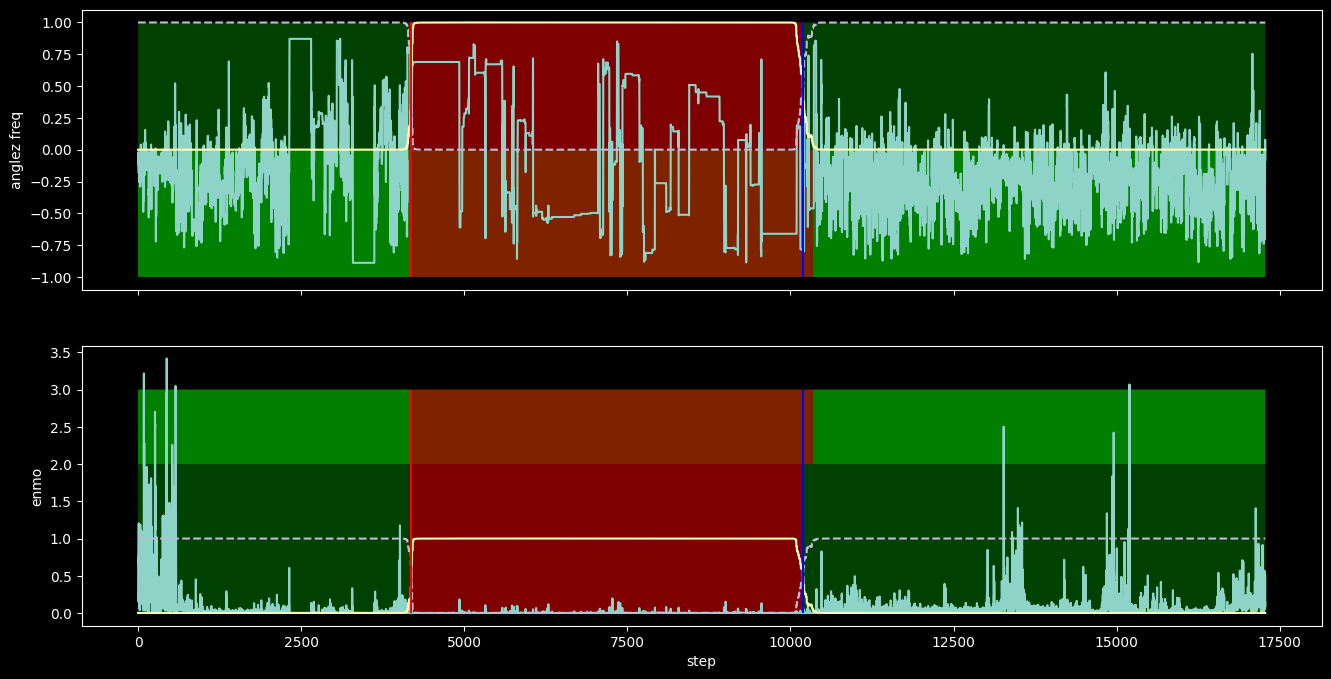

In [44]:
plot_predictions(index)
index += 1

## Evaluate whole series

In [ ]:
def evaluate_series(model, device, series, mode='hard'):
    model.eval()

    # Scale and clip acceleration data
    series[:, 0, :] = series[:, 0, :]/100
    series[:, 1, :] = torch.clamp(series[:, 1, :], max=1)

    series = series.to(device)
    
    with torch.autocast(device_type=str(device), dtype=torch.float16):
        output = model(series) # (batch, # classes, time)
        output = F.softmax(output, dim=1)

    if mode == 'hard':
        predictions = torch.squeeze(torch.argmax(output, dim=1))
    else:
        predictions = torch.squeeze(output)
    
    return [predictions]

def series_predict(series, mode='hard'):
    """
    Loads models and evaluates an entire series. Predictions are then voted on with either 'hard' or
    'soft' voting depending on mode selection
    """
    # Various initilizations
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')
    print('Predicting with ' + str(device))

    model_files = os.listdir('./trained_models')

    # Iterate over models and make predictions
    pred_list = []
    model_num = 0
    for file in model_files:
        checkpoint = torch.load('./trained_models/' + file)
        hparams = checkpoint['model_hparams']
        model = WaveNet(2, feat_sizes=hparams['feat sizes'], depths=hparams['depths']).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])

        predictions = evaluate_series(model, device, series, mode=mode)
        pred_list.append(predictions)
        model_num += 1
    
    return pred_list

def ensemble_voting(predictions, mode='hard'):
    """
    Takes a nested list of model predictions and computes voting results depending on
    mode selection.
    """

    # Stack predictions from each model
    stacked_preds = []
    for i in range(len(predictions)):
        stacked_preds.append(torch.stack(predictions[i], dim=0))

    # Stack predictions from all models
    stacked_preds = torch.stack(stacked_preds, dim=0).to('cpu') # (model num, num days, num steps) when mode = hard
                                                      # (model num, num classes, num days, num steps) when mode = soft

    if mode == 'hard':
        num_votes = torch.zeros((3, stacked_preds.shape[1], stacked_preds.shape[2]))

        # Awake votes
        indxs = torch.where(stacked_preds == 0)
        num_votes[0, indxs[1], indxs[2]] += 1
        # Asleep votes
        indxs = torch.where(stacked_preds == 1)
        num_votes[1, indxs[1], indxs[2]] += 1
        # Not wearing votes
        indxs = torch.where(stacked_preds == 2)
        num_votes[2, indxs[1], indxs[2]] += 1

        voted_predictions = torch.argmax(num_votes, dim=0) # (num_days, num steps)
    
    if mode == 'soft':
        summed_preds = torch.sum(stacked_preds, dim=0) # (num classes, num days, num steps)
        voted_predictions = torch.argmax(summed_preds, dim=0) # (num days, num steps)
    
    return voted_predictions

def get_series_predictions(series_df, index):
    """
    Returns the voted predictions of a series
    """
    id = series_df.series_id.unique()[index]

    series = torch.Tensor(np.reshape(series_df[series_df.series_id.isin([id])][['anglez', 'enmo']].to_numpy().T, (1, 2, -1)))

    predictions = series_predict(series, mode='hard')
    voted_preds = ensemble_voting(predictions, mode='hard')

    return voted_preds

def plot_series_preds(prediction, eval_dataset):
    onset_step, wakeup_step =  process_prediction(prediction)

    id = eval_dataset.series_id.unique()[index]

    series = eval_dataset[eval_dataset.series_id.isin([id])][['anglez', 'enmo']].to_numpy().T

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, squeeze=True, figsize=(16, 8))
    steps = np.arange(series.shape[-1])
    # labels = eval_dataset[index][1].numpy()

    # accuracy = np.sum(np.array([prediction == labels]))/prediction.shape[0]
    # print('Example accuracy = {:.4f}'.format(accuracy))

    num_days = series.shape[1]//17280+1
    day_steps = []
    for day in range(num_days):
        day_steps.append(day*17280)

    ax1.plot(steps, series[0, :])
    ax1.fill_between(steps, y1=100, y2=0, where=prediction[0]==0, facecolor='green', alpha=.5)
    ax1.fill_between(steps, y1=100, y2=0, where=prediction[0]==1, facecolor='red', alpha=.5)
    ax1.fill_between(steps, y1=100, y2=0, where=prediction[0]==2, facecolor='blue', alpha=.5)
    # ax1.fill_between(steps, y1=0, y2=-100, where=labels==0, facecolor='lime', alpha=.5)
    # ax1.fill_between(steps, y1=0, y2=-100, where=labels==1, facecolor='orangered', alpha=.5)
    # ax1.fill_between(steps, y1=0, y2=-100, where=labels==2, facecolor='blue', alpha=.5)
    ax1.vlines(onset_step, -100, 100, colors='r', label='onset')
    ax1.vlines(wakeup_step, -100, 100, colors='b', label='wakeup')
    ax1.vlines(day_steps, -100, 100, colors='w', label='wakeup')
    ax1.set_ylabel('anglez freq')

    ax2.plot(steps, series[1, :])
    ax2.fill_between(steps, y1=2, y2=0, where=prediction[0]==0, facecolor='green', alpha=.5)
    ax2.fill_between(steps, y1=2, y2=0, where=prediction[0]==1, facecolor='red', alpha=.5)
    ax2.fill_between(steps, y1=2, y2=0, where=prediction[0]==2, facecolor='blue', alpha=.5)
    # ax2.fill_between(steps, y1=3, y2=2, where=labels==0, facecolor='lime', alpha=.5)
    # ax2.fill_between(steps, y1=3, y2=2, where=labels==1, facecolor='orangered', alpha=.5)
    # ax2.fill_between(steps, y1=3, y2=2, where=labels==2, facecolor='blue', alpha=.5)
    ax2.vlines(onset_step, 0, 3, colors='r')
    ax2.vlines(wakeup_step, 0, 3, colors='b')
    ax2.vlines(day_steps, 0, 3, colors='w')
    ax2.set_xlabel('step')
    ax2.set_ylabel('enmo')
    
    # day = 24
    # plt.xlim([17280*(day-1), 17280*(day+3)])

    plt.show()
    plt.close()

index = 0

In [ ]:
torch.cuda.empty_cache()
vote_preds = get_series_predictions(train_series, index)
plot_series_preds(vote_preds, train_series)
index += 1

# Post-processing (series evaluation)

In [ ]:
def series_processing(series_df):
    """
    Creates and processes the enseble predictions on an entire series. The predictions are chunked based on the noon to noon day and then the usual post-processing is performed on each chunk.
    """

    ids = series_df.series_id.unique()
    event_steps = []
    event_list = []
    row_ids = []
    series_ids = []
    
    series_num = 0
    for id in ids:
        print('Evaluating series ' + id)

        # Organize series data and chunk indices
        series = series_df[series_df.series_id.isin([id])]
        series_data = torch.Tensor(np.reshape(series[['anglez', 'enmo']].to_numpy().T, (1, 2, -1)))
        print(series.timestamp)
        noon_steps = series.step[series.timestamp.str.contains('12:00:00')].to_list()
        print(noon_steps)
        chunk_indxs = [series.step.iloc[0]] + [step for step in noon_steps] + [series.step.iloc[-1]]
        chunk_indxs = list(zip(chunk_indxs, chunk_indxs[1:]))
        
        # Account for case where first or last timestamp in series is at noon
        chunk_indxs = [chunk_indxs[i] for i in range(len(chunk_indxs))
                       if chunk_indxs[i][0] != chunk_indxs[i][1]]
        
        # Make predictions on series
        predictions = series_predict(series_data, mode='hard')
        voted_preds = ensemble_voting(predictions, mode='hard')
        # Iterate through noon indices and process chunks
        for i in range(len(chunk_indxs)):
            print(voted_preds[0][chunk_indxs[i][0]:chunk_indxs[i][1]].numpy().shape[0])
            pred_chunk = voted_preds[0][chunk_indxs[i][0]:chunk_indxs[i][1]].numpy()
            onset, wakeup = process_prediction(pred_chunk)
            if not np.isnan(onset):
                event_steps.append(onset)
                event_list.append('onset')
                event_steps.append(wakeup)
                event_list.append('wakeup')
                series_ids.append(id)
                series_ids.append(id)

        series_num += 1
        if series_num > 10:
            break

    row_ids = [int(i) for i in range(len(event_list))]
    scores = [1.0 for _ in range(len(event_list))]

    # Create submission dataframe
    submission_df = pd.DataFrame({'row_id': row_ids,
                                  'series_id': series_ids, 
                                  'step': event_steps, 
                                  'event': event_list, 
                                  'score': scores})

    return submission_df

In [ ]:
submission_df = series_processing(train_series)

In [ ]:
test = torch.Tensor([0,1,3,6,1,1])
test2 = torch.Tensor([1,1,3,4,8,1])
torch.where((test == 1) & (test2 == 1))[0].shape[0]/torch.where(test2 == 1)[0].shape[0]

In [ ]:
from math import sqrt, pi, exp
SIGMA = 90
def gauss(mu, sigma=SIGMA):
    # guassian distribution function
    r = [mu - 360, mu - 300, mu - 240, mu - 180, mu - 150, mu - 120, mu - 90, mu - 60, mu - 36, mu - 12, 
         mu, mu + 12, mu + 36, mu + 60, mu + 90, mu + 120, mu + 150, mu + 180, mu + 240, mu + 300,  mu + 360]
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x - mu)**2/(2*sigma**2)) for x in r], r